# problem set 1
Wrriten by Shogo Nakano

## Set up

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym # use gymnasium followed documentation
from gymnasium import spaces
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7)})

pd.set_option('display.max_columns', None)

#### Environment

In [2]:
class Segment:
    def __init__(self, numActions, startObservation, p, terminal, done):
        self.numActions = numActions
        self.observation = startObservation
        self.p = p
        self.terminal = terminal
        self.action_space = spaces.Discrete(self.numActions) # {0:left, 1:right}
        self.observation_space = spaces.Discrete(2*self.terminal+1) # terminal means the length to the terminal
        self.done = done
        
    def step(self, action):
        assert self.action_space.contains(action)
        assert self.observation_space.contains(self.observation)
        assert self.action_space.n == 2
        assert self.observation != 0
        assert self.observation != (2*self.terminal)
        observation = self.observation
        done = self.done
        
        if action==0:
            observation_next = observation + np.random.choice([-1, 1],p=[self.p, 1-self.p])
        elif action==1:
            observation_next = observation + np.random.choice([-1, 1],p=[1-self.p, self.p])
            
        if observation_next == (2*self.terminal):
            done = True
        elif observation_next == 0:
            done = True
            
        self.done = done
        self.observation = observation_next
        reward=self.rewards(observation, observation_next, action)
        return [self.observation, reward, done]
    
    def rewards(self, observation, observation_next, action):
        if observation_next==(2*self.terminal):
            reward = 1.0
        elif observation_next==0:
            reward = -1.0
        else:
            reward = -0.05
        return reward
    
    def reset(self):
        observation = self.startObservation
        self.observation = observation
        self.done =False
        return observation

## (1) under the "Always try to go right policy"

#### Policy

In [3]:
def policy(observation):
    action = 1
    return action

#### Running an episode

In [4]:
def run_an_episode(policy=policy):
    t=0
    tMax = 50
    done =False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []

    env = Segment(numActions=2, startObservation=10, p=0.8, terminal=10, done=False)

    while t <tMax and done==False:
        action = policy(observation=observation)
        observation_next, reward, done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t += 1

    dta = pd.DataFrame(
                [range(0,t),
                 observations[0:t],
                 observations[1:(t+1)],
                 actions[0:t],
                 rewards]).transpose()

    dta.columns = ['t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    return dta

#### Table 2.1

In [5]:
dta = run_an_episode(policy=policy)

In [6]:
print('Table 2.1')
dta

Table 2.1


,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,-1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,-1.0,-2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,-2.0,-1.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,-1.0,0.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,0.0,1.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,1.0,2.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,2.0,3.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,3.0,2.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,2.0,3.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,3.0,4.0,1.0,-0.05,0.98,0.833748,-0.041687


This sample run reach right bound when t = 19.

#### Expected discount rewards

In [7]:
def run_multi_episodes(policy=policy):
    allEpisodes = pd.DataFrame()

    for e in range(0,1000):
        # compute discount reward
        t=0
        tMAX = 50
        done = False
        observation = 10
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2, startObservation=10, p=0.8, terminal=10, done=False)

        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1

        # get dataframe like table 2.1
        dta = pd.DataFrame(
                     [[e]*t,
                      range(0,t),
                      observations[0:t],
                      observations[1:(t+1)],
                      actions[0:t],
                      rewards]).transpose()
        dta.columns = ['episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']

        allEpisodes = pd.concat([allEpisodes, dta])
        
    return allEpisodes

In [8]:
# run 1000 times
allEpisodes = run_multi_episodes(policy=policy)

In [9]:
all_group = allEpisodes.groupby(['episode']).sum()['beta^t_reward']

#### Figure 2.2

In [10]:
def plot2_2(all_group):
    plt.hist(all_group, bins=11, color='blue')
    plt.title('the sum of discounted realized rewards across all episodes')
    #sns.kdeplot(all_group)
    plt.show()

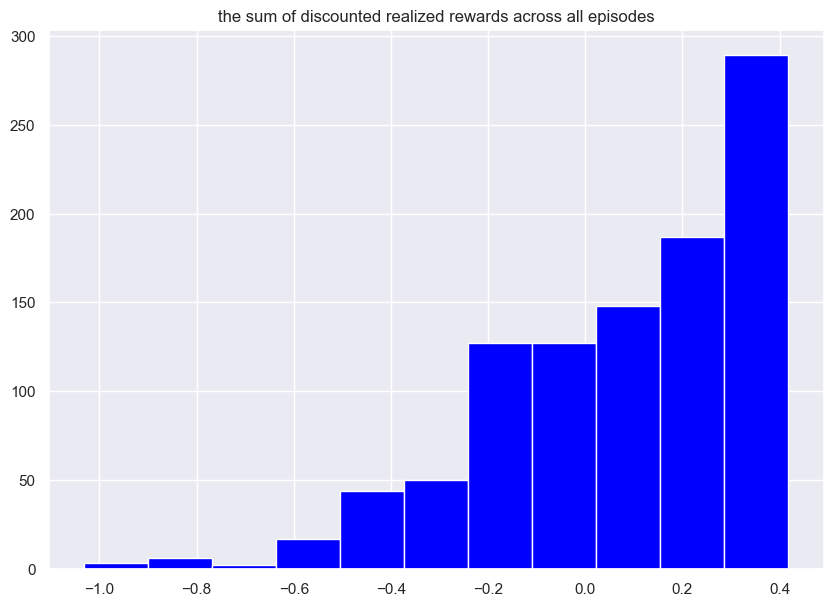

In [11]:
plot2_2(all_group)

Figure 2.2 shows the histogram of the sum of discounted realized rewards across all episodes.

#### Table 2.4
Table 2.4 presents summary statistics of the sum of discounted realized rewards across all episodes.

In [12]:
print('Table 2.4')
all_group.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

Table 2.4


count    1000.000000
mean        0.075731
std         0.257455
min        -1.031786
1%         -0.703081
5%         -0.387873
10%        -0.300785
25%        -0.017374
50%         0.084992
75%         0.302560
90%         0.418117
95%         0.418117
99%         0.418117
max         0.418117
Name: beta^t_reward, dtype: float64

#### Change Initial state

In [13]:
def change_initial_state(policy=policy):
    allEpisodes = pd.DataFrame()
    obs = range(1,20)
    for o in obs:
        # print(f'start {o}')
        for e in range(0,1000):
            t=0
            tMAX = 50
            done = False
            observation = np.int32(o)
            observations = [observation]
            rewards = []
            actions = []
            env = Segment(numActions=2,startObservation=observation,p=0.8,terminal=10,done=False)
            while t <tMAX and done==False:
                action = policy(observation=observation)
                observation_next,reward,done = env.step(action=action)
                observations.append(observation_next)
                rewards.append(reward)
                actions.append(action)
                observation = observation_next
                t+=1
            dta = pd.DataFrame(
                        [[o-10]*t,
                        [e]*t,
                        range(0,t),
                        observations[0:t],
                        observations[1:(t+1)],
                        actions[0:t],
                        rewards]).transpose()
            dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
            dta['observation'] = dta['observation'] - 10
            dta['observation_next'] = dta['observation_next'] - 10
            dta['beta'] = 0.98
            dta['beta^t'] = dta['beta']**dta['t']
            dta['beta^t_reward'] = dta['beta^t']*dta['reward']
            allEpisodes = pd.concat([allEpisodes, dta])
    
    return allEpisodes 

#### Table 2.6

In [14]:
allEpisodes = change_initial_state(policy=policy)

In [15]:
def table2_6(allEpisodes):
    pd.options.display.float_format = '{:.2f}'.format

    all_group = allEpisodes.groupby(['initial','episode']).sum()['beta^t_reward'].reset_index()
    df_wide = all_group.pivot(index='episode', columns='initial', values='beta^t_reward')
    all_group_initial = df_wide.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).transpose()

    return all_group, all_group_initial

In [16]:
all_group, all_group_initial = table2_6(allEpisodes)

In [17]:
print('Table 2.6')
all_group_initial

Table 2.6


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.00,1000.00,-0.67,0.30,-1.59,-1.17,-1.06,-1.00,-1.00,-0.67,-0.43,-0.26,-0.25,-0.07,-0.07
-8.00,1000.00,-0.55,0.30,-1.59,-1.35,-1.09,-1.03,-0.77,-0.55,-0.30,-0.21,-0.12,-0.02,-0.02
-7.00,1000.00,-0.48,0.29,-1.59,-1.17,-1.00,-0.88,-0.67,-0.43,-0.26,-0.16,-0.07,0.03,0.03
-6.00,1000.00,-0.40,0.28,-1.59,-1.15,-0.91,-0.77,-0.55,-0.39,-0.21,-0.02,-0.02,0.08,0.08
-5.00,1000.00,-0.34,0.28,-1.59,-1.12,-0.81,-0.74,-0.51,-0.34,-0.16,-0.07,0.03,0.14,0.14
-4.00,1000.00,-0.25,0.28,-1.59,-1.03,-0.77,-0.63,-0.39,-0.21,-0.02,0.08,0.08,0.19,0.19
-3.00,1000.00,-0.18,0.27,-1.59,-0.94,-0.67,-0.51,-0.34,-0.16,0.03,0.14,0.14,0.25,0.25
-2.00,1000.00,-0.10,0.28,-1.59,-0.91,-0.63,-0.47,-0.30,-0.02,0.08,0.19,0.30,0.30,0.30
-1.00,1000.00,0.00,0.26,-1.00,-0.74,-0.51,-0.34,-0.16,0.03,0.25,0.25,0.36,0.36,0.36


Table 2.6 presents summary statistics of the sum of discounted realized rewards across all episodes and initial states.

In [18]:
def kde(df):
    sns.set(rc={'figure.figsize':(10,7)})
    sns.set_palette("RdYlBu_r")
    plt.title('KDE Plot')
    sns.kdeplot(data=df, x='beta^t_reward', hue='initial')
    plt.show()

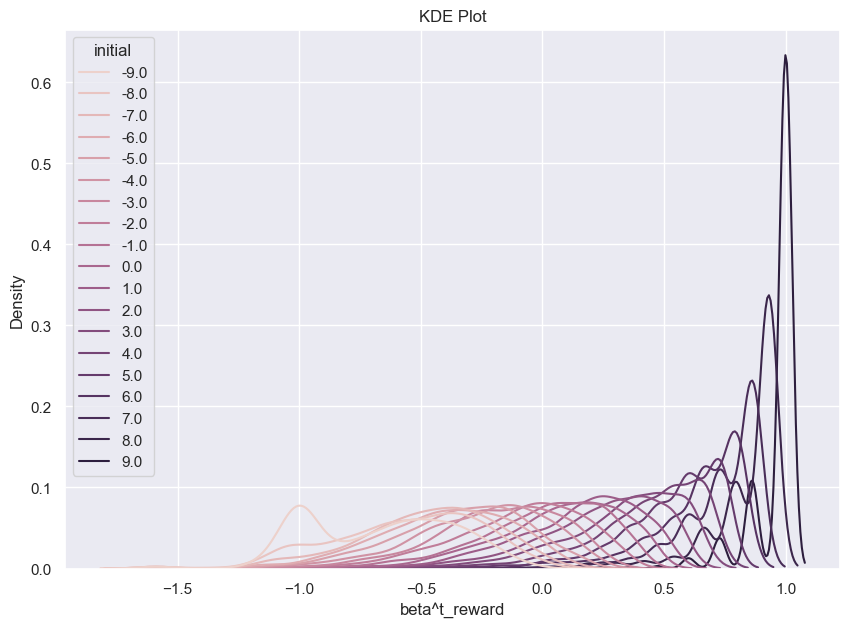

In [19]:
kde(all_group)

This is KDE plot of each initial state. It can be seen that the closer the initial state is to 10, the higher the expected value of the reward.

#### Figure 2.3

In [20]:
def figure2_3(all_group_initial):
    plt.scatter(all_group_initial.index, all_group_initial['mean'], color='black')
    plt.title('expected discounted rewards as a function of the initial states')
    plt.xlim(-10, 10)
    plt.xticks(range(-9, 10))
    plt.show()

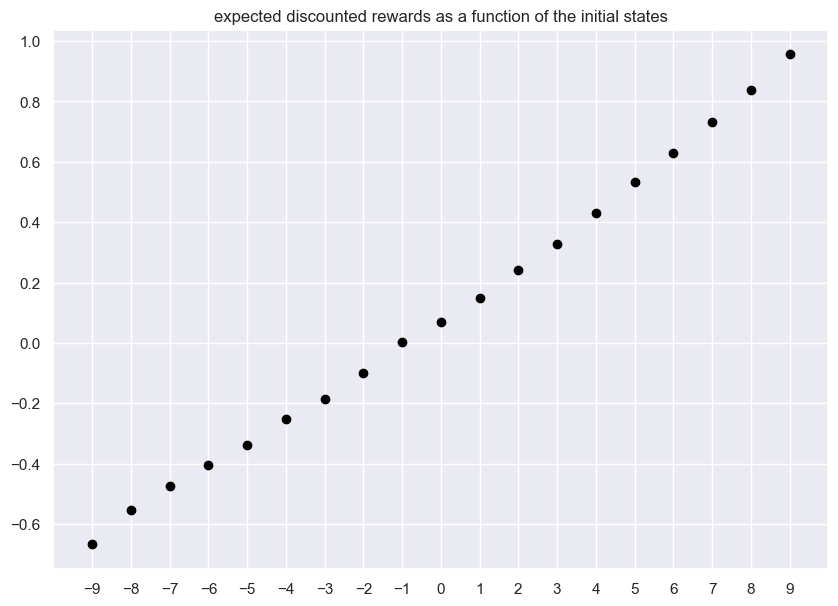

In [21]:
figure2_3(all_group_initial)

Figure 2.3 presents the estimates for the expected discounted rewards as a function of the initial states. The relationship is almost liner.

### transition matrix

In [22]:
def calc_transition_matrix(df):
    # range
    min_pos = -10
    max_pos = 10
    # define
    transition_df = df[['observation', 'observation_next']].dropna()
    # count
    counts = transition_df.groupby(['observation', 'observation_next']).size().unstack(fill_value=0)
    # compute probability
    probabilities = counts.div(counts.sum(axis=1), axis=0)
    # fill zero if not exist
    probabilities = probabilities.reindex(index=range(min_pos, max_pos+1), columns=range(min_pos, max_pos+1), fill_value=0)
    # return dataframe
    probabilities.iloc[0,0]=1
    probabilities.iloc[20,20]=1
    
    sns.heatmap(probabilities, cmap="YlGnBu", annot=True)
    plt.title('transition probability matrix')
    plt.show()
    #return probabilities

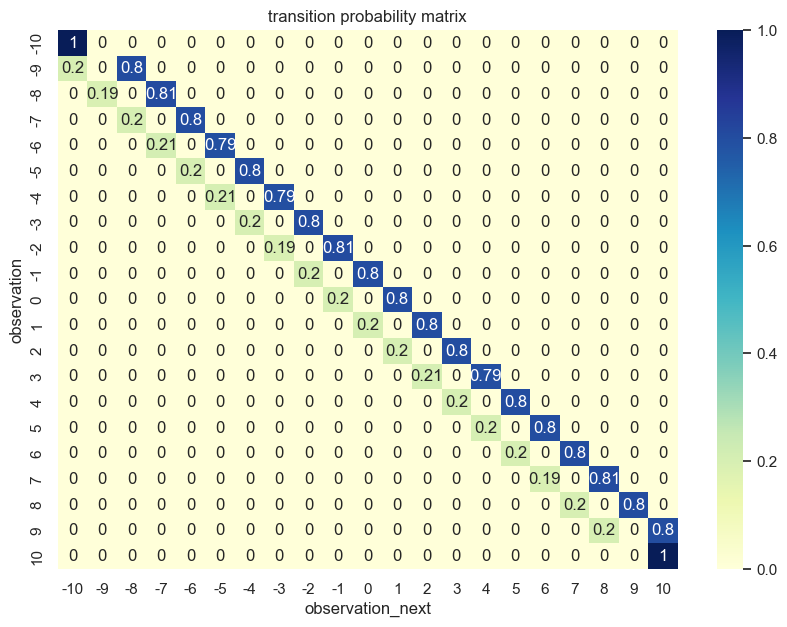

In [23]:
calc_transition_matrix(allEpisodes)

Note that this is the simulated data, so the result is not as same as expected from theory.

## (2)  under the "Always try to go left policy"

#### Policy

In [24]:
def policy(observation):
    action = 0
    return action

#### Running an episode

In [25]:
dta = run_an_episode(policy=policy)

#### Table 2.1

In [26]:
print('Table 2.1')
dta

Table 2.1


,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.00,0.00,-1.00,0.00,-0.05,0.98,1.00,-0.05
1,1.00,-1.00,0.00,0.00,-0.05,0.98,0.98,-0.05
2,2.00,0.00,-1.00,0.00,-0.05,0.98,0.96,-0.05
3,3.00,-1.00,-2.00,0.00,-0.05,0.98,0.94,-0.05
4,4.00,-2.00,-3.00,0.00,-0.05,0.98,0.92,-0.05
5,5.00,-3.00,-4.00,0.00,-0.05,0.98,0.90,-0.05
6,6.00,-4.00,-5.00,0.00,-0.05,0.98,0.89,-0.04
7,7.00,-5.00,-6.00,0.00,-0.05,0.98,0.87,-0.04
8,8.00,-6.00,-7.00,0.00,-0.05,0.98,0.85,-0.04
9,9.00,-7.00,-8.00,0.00,-0.05,0.98,0.83,-0.04


This sample run reaches the left bound when t = 11.

#### Expected discount rewards

In [27]:
allEpisodes = run_multi_episodes(policy=policy)

In [28]:
all_group = allEpisodes.groupby(['episode']).sum()['beta^t_reward']

#### Figure 2.2

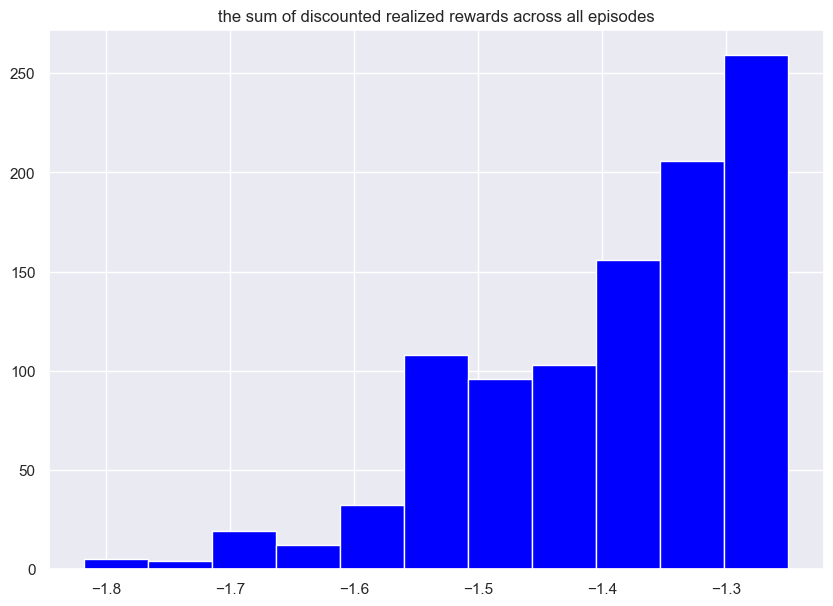

In [29]:
plot2_2(all_group)

#### Table 2.4

In [30]:
print('Table 2.4')
all_group.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

Table 2.4


count   1000.00
mean      -1.40
std        0.11
min       -1.82
1%        -1.70
5%        -1.59
10%       -1.56
25%       -1.48
50%       -1.39
75%       -1.30
90%       -1.25
95%       -1.25
99%       -1.25
max       -1.25
Name: beta^t_reward, dtype: float64

The mean realized reward is -1.4. this is lower than (1), which is under "always go right policy"

#### Change Initial state

In [31]:
allEpisodes = change_initial_state(policy=policy)

#### Table 2.6

In [32]:
all_group, all_group_initial = table2_6(allEpisodes)

In [33]:
print('Table 2.6')
all_group_initial

Table 2.6


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.00,1000.00,-1.02,0.04,-1.37,-1.17,-1.12,-1.06,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
-8.00,1000.00,-1.07,0.06,-1.44,-1.30,-1.20,-1.14,-1.09,-1.03,-1.03,-1.03,-1.03,-1.03,-1.03
-7.00,1000.00,-1.12,0.08,-1.50,-1.41,-1.27,-1.22,-1.12,-1.12,-1.06,-1.06,-1.06,-1.06,-1.06
-6.00,1000.00,-1.16,0.09,-1.67,-1.44,-1.35,-1.25,-1.20,-1.14,-1.09,-1.09,-1.09,-1.09,-1.09
-5.00,1000.00,-1.21,0.10,-1.80,-1.54,-1.41,-1.32,-1.27,-1.17,-1.12,-1.12,-1.12,-1.12,-1.12
-4.00,1000.00,-1.25,0.10,-1.76,-1.59,-1.44,-1.39,-1.30,-1.25,-1.20,-1.14,-1.14,-1.14,-1.14
-3.00,1000.00,-1.29,0.11,-1.78,-1.61,-1.50,-1.42,-1.32,-1.27,-1.22,-1.17,-1.17,-1.17,-1.17
-2.00,1000.00,-1.33,0.11,-1.82,-1.63,-1.52,-1.48,-1.39,-1.30,-1.25,-1.20,-1.20,-1.20,-1.20
-1.00,1000.00,-1.37,0.12,-1.88,-1.71,-1.58,-1.54,-1.46,-1.37,-1.27,-1.22,-1.22,-1.22,-1.22


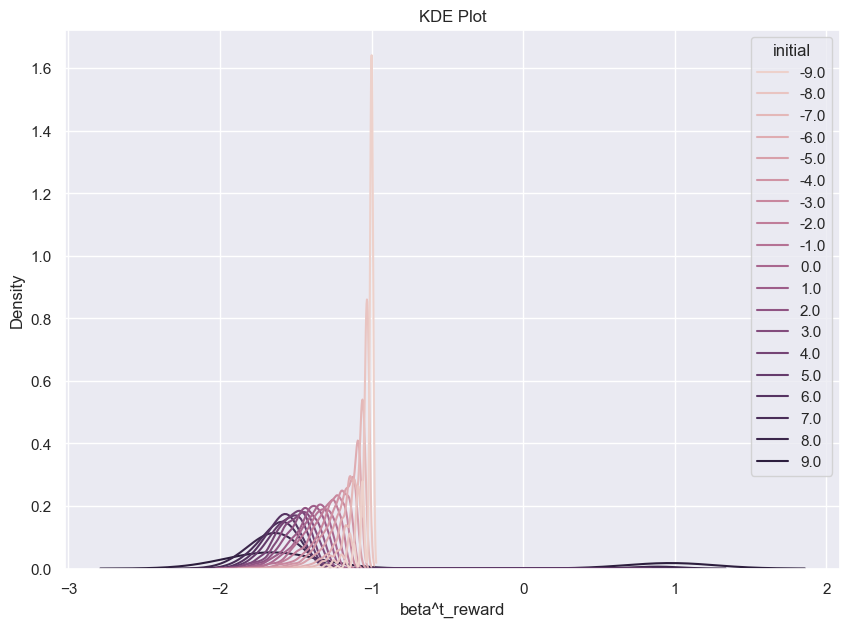

In [34]:
kde(all_group)

#### Figure 2.3

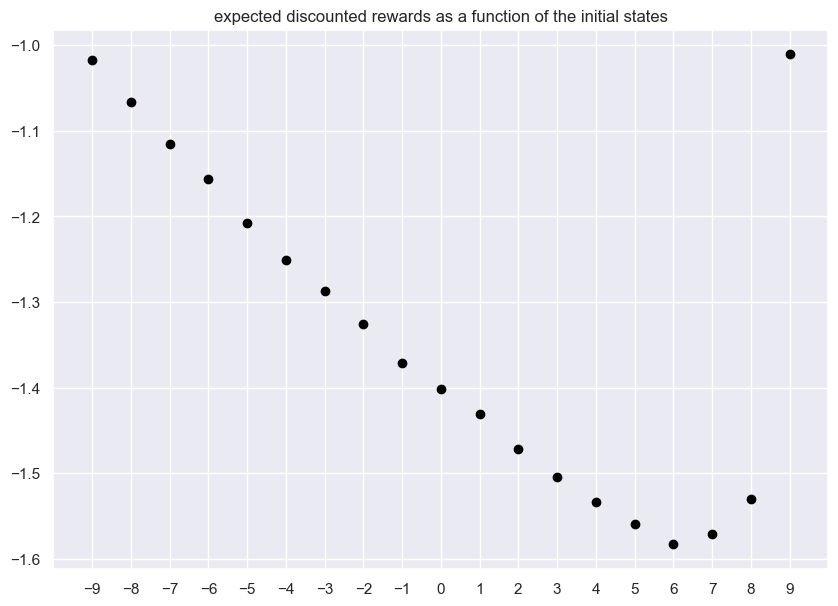

In [35]:
figure2_3(all_group_initial)

The relationship is not liner. 

The expected reward is minimized when the initial state is 6. When the initial state is 9 or 8, 
the probability of reaching 10 at time t=1 or t=2 is relatively high, so the expected reward is higher than that of 6. 

On the other hand, when the initial state is -9 or -8, the process reaches -10 relatively early and as a result, obtains
-1. However, the number of -0.05 losses during the process is reduced, resulting in smaller losses compared to initial state = 6.

#### Transition matrix

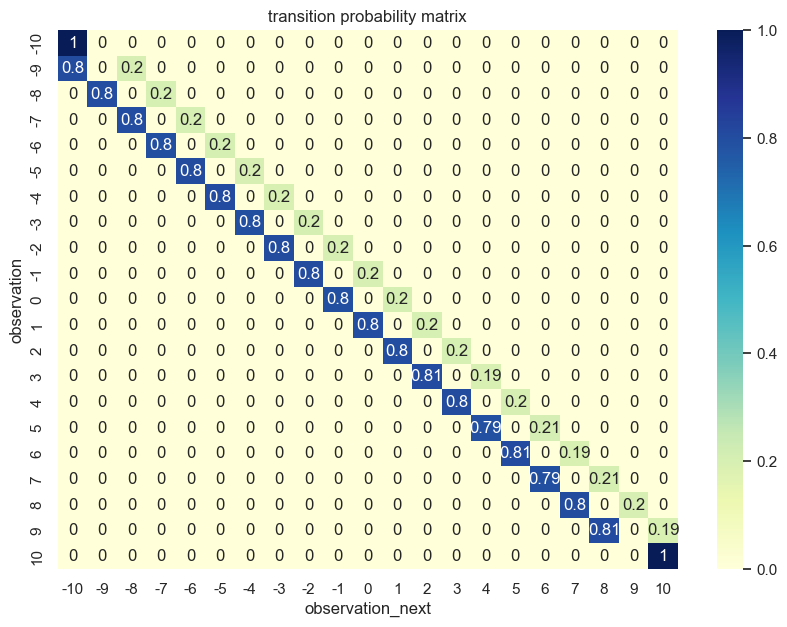

In [36]:
calc_transition_matrix(allEpisodes)

## (3) under a policy "tries to go left with 50%, to go right 50%"

#### Policy

In [37]:
def policy(observation):
    action = np.random.choice([0, 1], p=[0.5, 0.5])
    return action

#### Running an episode

In [38]:
dta = run_an_episode(policy=policy)

#### Table 2.1

In [39]:
print('Table 2.1')
dta

Table 2.1


,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.00,0.00,1.00,1.00,-0.05,0.98,1.00,-0.05
1,1.00,1.00,0.00,0.00,-0.05,0.98,0.98,-0.05
2,2.00,0.00,1.00,1.00,-0.05,0.98,0.96,-0.05
3,3.00,1.00,2.00,1.00,-0.05,0.98,0.94,-0.05
4,4.00,2.00,3.00,1.00,-0.05,0.98,0.92,-0.05
5,5.00,3.00,2.00,0.00,-0.05,0.98,0.90,-0.05
6,6.00,2.00,3.00,1.00,-0.05,0.98,0.89,-0.04
7,7.00,3.00,2.00,0.00,-0.05,0.98,0.87,-0.04
8,8.00,2.00,3.00,0.00,-0.05,0.98,0.85,-0.04
9,9.00,3.00,4.00,1.00,-0.05,0.98,0.83,-0.04


This example run reaches 10 when t=39.

#### Expected discount rewards

In [40]:
allEpisodes = run_multi_episodes(policy=policy)

In [41]:
all_group = allEpisodes.groupby(['episode']).sum()['beta^t_reward']

#### Figure 2.2

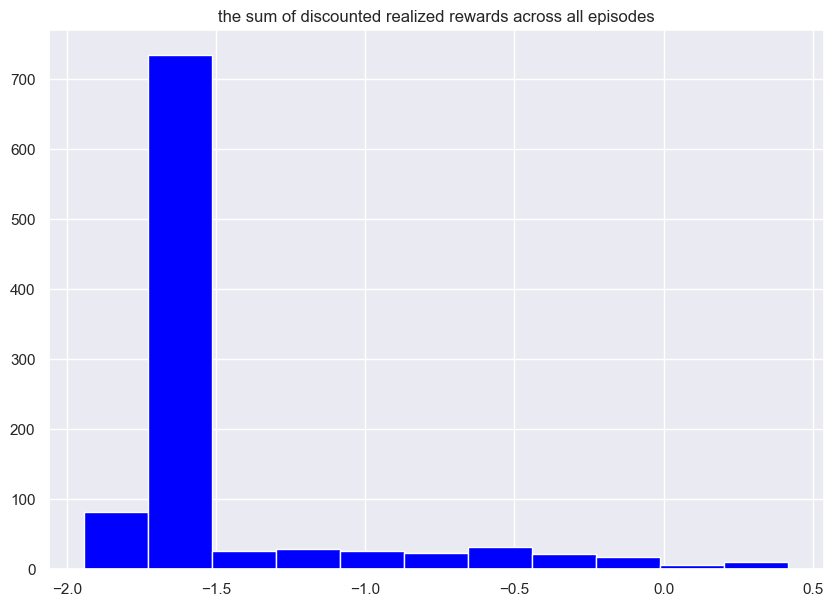

In [42]:
plot2_2(all_group)

#### Table 2.4

In [43]:
print('Table 2.4')
all_group.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

Table 2.4


count   1000.00
mean      -1.45
std        0.42
min       -1.94
1%        -1.92
5%        -1.79
10%       -1.59
25%       -1.59
50%       -1.59
75%       -1.59
90%       -0.84
95%       -0.39
99%        0.19
max        0.42
Name: beta^t_reward, dtype: float64

#### Change Initial state

In [44]:
allEpisodes = change_initial_state(policy=policy)

#### Table 2.6

In [45]:
all_group, all_group_initial = table2_6(allEpisodes)

In [46]:
print('Table 2.6')
all_group_initial

Table 2.6


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.00,1000.00,-1.14,0.22,-1.93,-1.83,-1.59,-1.59,-1.17,-1.00,-1.00,-1.00,-1.00,-1.00,-0.88
-8.00,1000.00,-1.30,0.26,-1.94,-1.90,-1.70,-1.59,-1.59,-1.20,-1.07,-1.03,-1.03,-1.03,-0.91
-7.00,1000.00,-1.40,0.25,-1.93,-1.91,-1.78,-1.61,-1.59,-1.46,-1.17,-1.06,-1.06,-1.06,-0.26
-6.00,1000.00,-1.47,0.23,-1.94,-1.92,-1.84,-1.67,-1.59,-1.59,-1.30,-1.14,-1.09,-0.97,-0.39
-5.00,1000.00,-1.50,0.22,-1.93,-1.91,-1.80,-1.71,-1.59,-1.59,-1.37,-1.17,-1.12,-0.74,-0.16
-4.00,1000.00,-1.53,0.22,-1.94,-1.92,-1.84,-1.73,-1.59,-1.59,-1.51,-1.25,-1.20,-0.55,-0.12
-3.00,1000.00,-1.53,0.25,-1.93,-1.91,-1.83,-1.71,-1.59,-1.59,-1.59,-1.27,-1.00,-0.43,0.03
-2.00,1000.00,-1.54,0.27,-1.94,-1.94,-1.85,-1.73,-1.59,-1.59,-1.59,-1.30,-0.97,-0.30,-0.12
-1.00,1000.00,-1.51,0.32,-1.93,-1.93,-1.83,-1.71,-1.59,-1.59,-1.59,-1.12,-0.74,-0.16,0.25


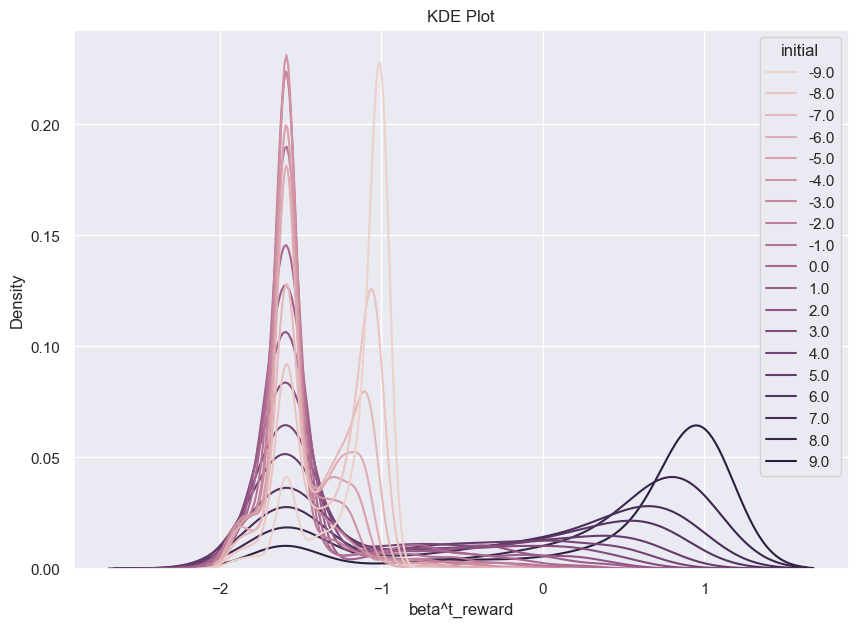

In [47]:
kde(all_group)

#### Figure 2.3

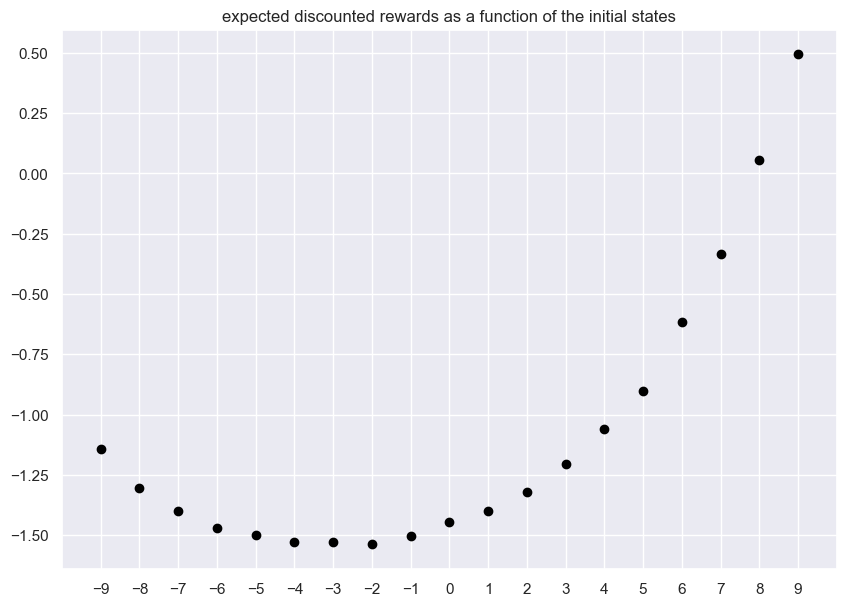

In [48]:
figure2_3(all_group_initial)

The relationship is U-shape. The logic is almost same as the case of 'always left policy.'

the only difference is this pilicy yields 50-50 chance to move left or right. Thus, the initial state which gets the lowest expected rewards is -2.

#### Transition matrix

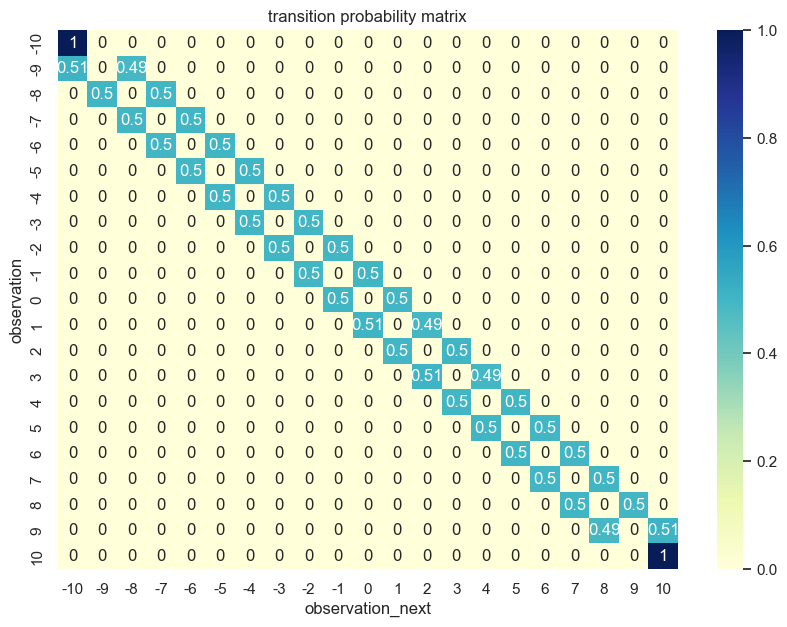

In [49]:
calc_transition_matrix(allEpisodes)

the transition probability is 50-50 in all states.